# Recommendation System - Movie Recommendation
## This notebook applies Recommendation Engine concepts and techniques to a real-world Movie Recommender System
### Task: Building a Movie Recommender system with the following methods:
- Popularity
- Content Filter
- Collaborative Filter
- Matrix Factorization

### Also, trying the following libraries on the dataset:
- Turicreate
- Surprise


### Import the necessary libraries

In [22]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

### Load the data

In [3]:
movies = pd.read_csv("movies.csv", delimiter="::")
ratings = pd.read_csv("ratings.csv", delimiter="::")
# tags = pd.read_csv("tags.csv")

c:\Users\mayur\OneDrive - George Brown College\Documents\GBC\ML2\.ml2-venv\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
c:\Users\mayur\OneDrive - George Brown College\Documents\GBC\ML2\.ml2-venv\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [4]:
print(movies.columns)
print(ratings.columns)
# print(tags.columns)

Index(['movieId', 'title', 'genres'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


# 1. Popularity

In [48]:
# Creating a new DataFrame with the average rating for each movie
average_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

In [49]:
# Merge the movies DataFrame with the average_ratings DataFrame
movies1 = pd.merge(movies, average_ratings, on='movieId')

In [50]:
# Create a new DataFrame with the count of ratings for each movie
ratings_count = ratings.groupby('movieId')['rating'].count().reset_index()
ratings_count.rename(columns={'rating': 'num_ratings'}, inplace=True)

In [51]:
# Merge the movies DataFrame with the ratings_count DataFrame
movies1 = pd.merge(movies1, ratings_count, on='movieId')

# Sort the movies DataFrame by the average rating and number of ratings
movies1 = movies1.sort_values(['average_rating', 'num_ratings'], ascending=False)

# Create a DataFrame for each user's top 5 recommendations
recommendations = pd.DataFrame(columns=['user_id', 'movie_id', 'score', 'rank'])

In [52]:
for user_id in range(1, 6):
    user_ratings = ratings[ratings['userId'] == user_id]
    user_movies = movies1[~movies1['movieId'].isin(user_ratings['movieId'])]
    user_recommendations = user_movies.head(5)[['movieId', 'title', 'genres', 'average_rating']]
    user_recommendations['user_id'] = user_id
    user_recommendations.rename(columns={'movieId': 'movie_id', 'average_rating': 'score'}, inplace=True)
    user_recommendations['rank'] = range(1, 6)
    recommendations = pd.concat([recommendations, user_recommendations[['user_id', 'movie_id', 'score', 'rank']]])


In [53]:
recommendations

,user_id,movie_id,score,rank
744,1,787,5.0,1
3010,1,3233,5.0,2
926,1,989,5.0,3
1652,1,1830,5.0,4
2955,1,3172,5.0,5
744,2,787,5.0,1
3010,2,3233,5.0,2
926,2,989,5.0,3
1652,2,1830,5.0,4
2955,2,3172,5.0,5


# 2. Content Filter

In [24]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


## TF-IDF Vectorizer on Metadata

In [25]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies.index.tolist())
print(tfidf_df.shape)

(3883, 20)


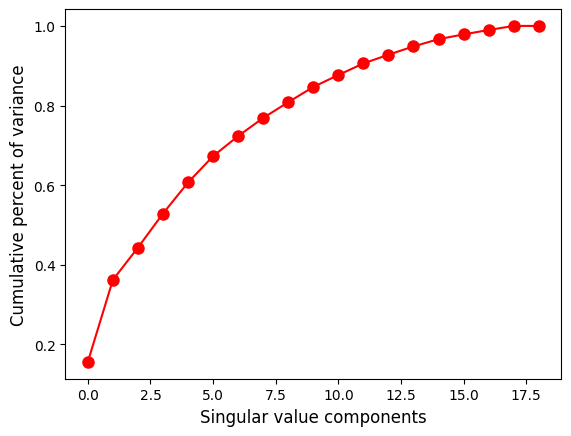

In [26]:
svd = TruncatedSVD(n_components=19)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [27]:
n = 20
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=movies.title.tolist())

In [28]:
latent_matrix_1_df.shape

(3883, 19)

In [29]:
latent_matrix_1_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Toy Story (1995),0.115687,0.357232,0.002974,-0.063556,-0.050127,-0.107915,0.191194,0.610724,0.064025,0.002747,0.181453,-0.408850,-0.180056,-0.025713,-0.005629,0.420432,-0.038705,0.125267,-1.718236e-17
Jumanji (1995),0.021029,0.037461,0.121268,0.006927,-0.092843,-0.260265,0.203342,0.658000,0.043430,-0.002113,-0.083026,0.209179,-0.112632,-0.021105,-0.015795,-0.386058,0.062183,0.462495,1.352208e-16
Grumpier Old Men (1995),0.274386,0.642562,0.046693,0.694419,0.157187,0.017726,0.005593,-0.031968,0.004605,-0.000288,-0.019147,-0.012339,-0.023730,-0.013799,-0.004614,0.005260,0.000285,-0.003119,4.914987e-17
Waiting to Exhale (1995),0.842228,0.499938,-0.106980,-0.160830,-0.026873,0.016574,0.003316,-0.033790,-0.022763,-0.005270,-0.021088,0.010166,0.001210,-0.003557,-0.007082,0.009146,0.000604,0.003392,2.064663e-18
Father of the Bride Part II (1995),0.298217,0.936961,-0.078427,-0.147266,-0.041892,0.030470,-0.006220,-0.041995,-0.015243,-0.004040,-0.009514,0.018802,0.000607,-0.001120,-0.006905,0.009570,-0.000116,0.003604,4.713149e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents (2000),0.298217,0.936961,-0.078427,-0.147266,-0.041892,0.030470,-0.006220,-0.041995,-0.015243,-0.004040,-0.009514,0.018802,0.000607,-0.001120,-0.006905,0.009570,-0.000116,0.003604,4.713149e-18
Requiem for a Dream (2000),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,-2.284827e-18
Tigerland (2000),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,-2.284827e-18
Two Family House (2000),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,-2.284827e-18


# 3. Collaborative Filter

In [6]:
user_movies_data = ratings.pivot(index = ['movieId'], columns = ['userId'], values = 'rating').fillna(0)

In [8]:
user_movies_data

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# finding the list of titles present in the ratings with the movieId
merged = pd.merge(movies, ratings, on='movieId')
titles = merged['title'].unique().tolist()

3706

In [18]:
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(user_movies_data)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index=titles)

In [19]:
latent_matrix_2_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),132.784373,-14.058038,-17.340275,2.518697,55.508155,7.595662,-0.035543,7.419389,-5.080137,-27.910457,...,-4.668785,-3.483207,1.541905,-1.218904,2.889441,-3.883034,1.020387,3.210254,2.197249,-1.580206
Jumanji (1995),44.573399,-20.000973,5.857215,-16.107409,4.262058,-2.169591,-13.422493,1.170188,4.537870,-8.881418,...,-0.704048,0.116710,-1.416003,-0.628955,1.579837,-2.172310,0.423329,-2.270187,1.309366,0.040302
Grumpier Old Men (1995),26.061632,-11.214055,-7.227290,-14.062228,2.594795,2.326935,-2.418637,6.495407,-1.922107,0.955058,...,-2.132297,-1.416290,-1.429124,0.184148,1.078253,1.230944,0.438841,0.890074,1.130133,4.107016
Waiting to Exhale (1995),10.078310,-1.989030,-7.102705,-7.808539,-1.168943,0.549981,-2.255726,-2.012778,1.381023,1.046473,...,0.213362,-0.084919,-0.903217,0.616245,1.231460,1.173901,-0.492874,1.632419,-0.804736,1.863250
Father of the Bride Part II (1995),18.395406,-9.055474,-7.171111,-14.964850,1.917957,3.063568,-1.961753,4.847974,-1.605679,-0.106712,...,0.515307,0.318241,0.777665,0.476084,1.463041,1.624874,1.554705,1.016007,-0.246301,1.261982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents (2000),47.975035,-8.135795,-22.778547,8.547096,5.335573,-3.448147,-8.520965,10.735115,-3.917170,7.980572,...,4.893703,4.853545,-0.797342,4.507708,-7.492760,1.472954,-5.974135,5.361834,0.924072,-4.117616
Requiem for a Dream (2000),24.457903,3.746270,-12.838007,7.045934,-6.276300,-11.966487,-7.286284,-0.539983,2.006429,1.040309,...,-0.701262,-1.632060,0.133231,0.741068,-0.531309,2.268904,-2.421593,-2.612787,-0.961709,0.376843
Tigerland (2000),4.951244,1.258366,-1.025073,0.189323,-2.343650,-1.504852,-2.011101,0.402279,0.464817,0.813349,...,0.461729,-1.232271,-0.269856,0.030899,0.747704,1.263315,0.377846,0.027990,1.084007,-0.365669
Two Family House (2000),2.208159,1.520669,-2.024009,0.574609,-0.385178,-1.108706,-2.178415,-0.500713,0.047734,1.301535,...,-0.792553,-0.020248,-0.460993,0.086432,-0.041769,0.486799,-0.396763,-0.232315,-0.541703,-0.547024


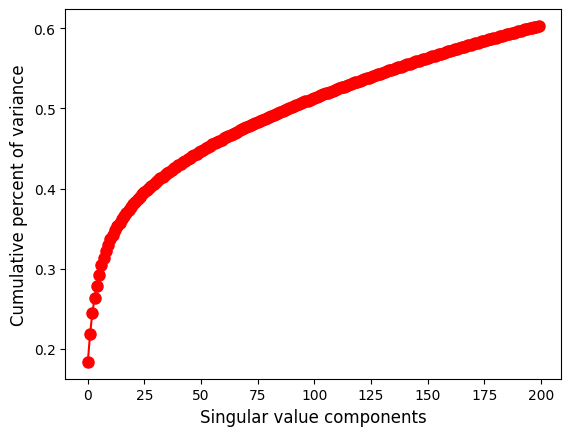

In [20]:
# plot variance expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [34]:
# keeping on those movies in latent_matrix_1_df which are also in latent_matrix_2_df
idx_set = set(latent_matrix_2_df.index)
latent_matrix_1_df_filtered = latent_matrix_1_df.loc[idx_set]

In [35]:
latent_matrix_1_df_filtered

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Timecop (1994),0.035867,0.025954,0.542854,-0.044499,-0.188085,-0.550723,0.394034,-0.402662,0.022969,0.003339,0.013434,-0.205668,-0.034912,-0.002312,-0.011927,-0.017510,0.003973,-0.024318,-5.846062e-17
"Lawnmower Man, The (1992)",0.055939,0.023822,0.774716,-0.055602,-0.257480,-0.167267,0.406061,-0.317730,-0.034341,-0.001535,0.016026,-0.167849,-0.025017,-0.042440,-0.008894,-0.018856,-0.004182,-0.020578,-6.411526e-17
All the King's Men (1949),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,-2.284827e-18
Buck and the Preacher (1972),0.005376,0.006245,0.008349,0.000071,-0.008392,-0.017157,-0.004699,0.002470,-0.008776,-0.001186,-0.009205,0.004738,-0.012940,-0.004760,0.999471,0.000033,-0.001119,0.012239,1.035402e-16
Repossessed (1990),0.298217,0.936961,-0.078427,-0.147266,-0.041892,0.030470,-0.006220,-0.041995,-0.015243,-0.004040,-0.009514,0.018802,0.000607,-0.001120,-0.006905,0.009570,-0.000116,0.003604,4.713149e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Death in Brunswick (1991),0.298217,0.936961,-0.078427,-0.147266,-0.041892,0.030470,-0.006220,-0.041995,-0.015243,-0.004040,-0.009514,0.018802,0.000607,-0.001120,-0.006905,0.009570,-0.000116,0.003604,4.713149e-18
"Run Silent, Run Deep (1958)",0.027231,-0.000325,0.048950,0.027782,-0.038159,-0.085745,-0.073750,-0.026325,-0.112362,0.006884,0.916757,0.356048,-0.034612,0.004457,0.002704,-0.005580,-0.002406,0.001158,-9.736483e-17
Miller's Crossing (1990),0.941785,-0.317600,-0.072852,-0.075653,0.007299,-0.009845,0.012238,-0.003142,-0.017167,-0.003386,-0.021219,-0.006169,0.001148,-0.004138,-0.002847,0.002924,0.001057,0.001021,-2.284827e-18
"Lodger, The (1926)",0.052671,0.001587,0.639440,-0.035086,-0.197561,0.708022,0.121445,0.089098,-0.120136,-0.009883,0.008926,0.033312,0.013277,-0.088557,0.003774,-0.007176,-0.016926,0.002335,6.367670e-18


In [36]:
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df_filtered.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df_filtered, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
# dictDf = {'collaborative': score_2} 
similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Ferris Bueller's Day Off (1986),1.000000,0.588695,0.794347
"Idolmaker, The (1980)",1.000000,0.136432,0.568216
"Hunt for Red October, The (1990)",1.000000,0.531703,0.765851
Aladdin and the King of Thieves (1996),1.000000,0.442304,0.721152
Funny Face (1957),1.000000,0.238118,0.619059
Two Much (1996),1.000000,0.150675,0.575337
House Party (1990),1.000000,0.329213,0.664606
"Fistful of Dollars, A (1964)",1.000000,0.308799,0.654400
"Amityville Horror, The (1979)",1.000000,0.267360,0.633680
"Beautician and the Beast, The (1997)",0.938841,0.287785,0.613313


# 4. Hybrid Recommendation System

In [37]:
def recommend_similar_movies(title):
    # take the latent vectors for a selected movie from both content 
    # and collaborative matrixes
    a_1 = np.array(latent_matrix_1_df_filtered.loc['Toy Story (1995)']).reshape(1, -1)
    a_2 = np.array(latent_matrix_2_df.loc["Toy Story (1995)"]).reshape(1, -1)

    # calculate the similartity of this movie with the others in the list
    score_1 = cosine_similarity(latent_matrix_1_df_filtered, a_1).reshape(-1)
    score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

    # an average measure of both content and collaborative 
    hybrid = ((score_1 + score_2)/2.0)

    # form a data frame of similar movies 
    dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
    # dictDf = {'collaborative': score_2} 
    similar = pd.DataFrame(dictDf, index = latent_matrix_2_df.index )

    #sort it on the basis of either: content, collaborative or hybrid, 
    # here : content
    similar.sort_values('content', ascending=False, inplace=True)

    print(similar[1:].head(11))

In [38]:
recommend_similar_movies("Toy Story (1995)")

                                         content  collaborative    hybrid
Ferris Bueller's Day Off (1986)         1.000000       0.588695  0.794347
Idolmaker, The (1980)                   1.000000       0.136432  0.568216
Hunt for Red October, The (1990)        1.000000       0.531703  0.765851
Aladdin and the King of Thieves (1996)  1.000000       0.442304  0.721152
Funny Face (1957)                       1.000000       0.238118  0.619059
Two Much (1996)                         1.000000       0.150675  0.575337
House Party (1990)                      1.000000       0.329213  0.664606
Fistful of Dollars, A (1964)            1.000000       0.308799  0.654400
Amityville Horror, The (1979)           1.000000       0.267360  0.633680
Beautician and the Beast, The (1997)    0.938841       0.287785  0.613313
Bonheur, Le (1965)                      0.938841       0.013439  0.476140


In [39]:
recommend_similar_movies("GoldenEye (1995)")

                                         content  collaborative    hybrid
Ferris Bueller's Day Off (1986)         1.000000       0.588695  0.794347
Idolmaker, The (1980)                   1.000000       0.136432  0.568216
Hunt for Red October, The (1990)        1.000000       0.531703  0.765851
Aladdin and the King of Thieves (1996)  1.000000       0.442304  0.721152
Funny Face (1957)                       1.000000       0.238118  0.619059
Two Much (1996)                         1.000000       0.150675  0.575337
House Party (1990)                      1.000000       0.329213  0.664606
Fistful of Dollars, A (1964)            1.000000       0.308799  0.654400
Amityville Horror, The (1979)           1.000000       0.267360  0.633680
Beautician and the Beast, The (1997)    0.938841       0.287785  0.613313
Bonheur, Le (1965)                      0.938841       0.013439  0.476140


In [40]:
recommend_similar_movies("Mission: Impossible (1996)")

                                         content  collaborative    hybrid
Ferris Bueller's Day Off (1986)         1.000000       0.588695  0.794347
Idolmaker, The (1980)                   1.000000       0.136432  0.568216
Hunt for Red October, The (1990)        1.000000       0.531703  0.765851
Aladdin and the King of Thieves (1996)  1.000000       0.442304  0.721152
Funny Face (1957)                       1.000000       0.238118  0.619059
Two Much (1996)                         1.000000       0.150675  0.575337
House Party (1990)                      1.000000       0.329213  0.664606
Fistful of Dollars, A (1964)            1.000000       0.308799  0.654400
Amityville Horror, The (1979)           1.000000       0.267360  0.633680
Beautician and the Beast, The (1997)    0.938841       0.287785  0.613313
Bonheur, Le (1965)                      0.938841       0.013439  0.476140


# 5. Matrix Factorization

- R – The user-movie rating matrix
- K – Number of latent features
- alpha – Learning rate for stochastic gradient descent
- beta – Regularization parameter for bias
- iterations – Number of iterations to perform stochastic gradient descent

In [46]:
class MF():

    # Initializing the user-movie rating matrix, no. of latent features, alpha and beta.
    def __init__(self, R, K, alpha, beta, iterations):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    # Initializing user-feature and movie-feature matrix 
    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initializing the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # List of training samples
        self.samples = [
        (i, j, self.R[i, j])
        for i in range(self.num_users)
        for j in range(self.num_items)
        if self.R[i, j] > 0
        ]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in tqdm(range(self.iterations)):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 20 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    # Computing total mean squared error
    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    # Ratings for user i and moive j
    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Full user-movie rating matrix
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)

In [42]:
R= np.array(ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0))

In [47]:
mf = MF(R, K=20, alpha=0.001, beta=0.01, iterations=100)
training_process = mf.train()
print()
print("P x Q:")
print(mf.full_matrix())
print()

 20%|██        | 20/100 [03:52<15:17, 11.46s/it]

Iteration: 20 ; error = 901.1927


 40%|████      | 40/100 [07:45<12:09, 12.15s/it]

Iteration: 40 ; error = 886.3090


 60%|██████    | 60/100 [11:44<07:53, 11.85s/it]

Iteration: 60 ; error = 851.2711


 80%|████████  | 80/100 [15:37<03:54, 11.73s/it]

Iteration: 80 ; error = 815.6301


100%|██████████| 100/100 [19:32<00:00, 11.72s/it]

Iteration: 100 ; error = 786.0965

P x Q:
[[4.5290419  3.41629277 3.39212502 ... 3.89676975 4.15540763 3.98792799]
 [4.2572865  3.25387767 3.30282419 ... 3.69439013 3.92251147 3.63831196]
 [3.93902245 3.23688638 3.5063052  ... 3.76924078 4.10100052 3.89711265]
 ...
 [3.8935649  3.27498802 3.12581872 ... 3.57984063 3.8787592  3.77854439]
 [4.16646499 3.33731869 3.06207533 ... 3.59803491 3.90569518 3.83523996]
 [3.09976116 2.43165177 2.17921763 ... 3.28486702 3.57920393 3.49982798]]



# Turicreate - Python Library for easy recommendation engine building

### Import the library

In [10]:
import turicreate

### Create a SFrame for training and testing data

In [8]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, random_state=1)

In [11]:
train_data = turicreate.SFrame(ratings_train)
test_data = turicreate.SFrame(ratings_test)

### Popularity Recommender - Cold Start problem

In [12]:
popularity_model = turicreate.popularity_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating')

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 800167 observations with 6040 users and 3688 items.

Data prepared in: 0.958589s

800167 observations to process; with 3688 unique items.

### Recommend some top 5 movies to users 1, 2, 3, 4, 5
- Use Popularity model

In [13]:
popularity_recomm = popularity_model.recommend(users=[1,2,3,4,5],k=5)
popularity_recomm.print_rows(num_rows=25)

+--------+---------+-------+------+
| userId | movieId | score | rank |
+--------+---------+-------+------+
|   1    |   578   |  5.0  |  1   |
|   1    |   787   |  5.0  |  2   |
|   1    |   3233  |  5.0  |  3   |
|   1    |   666   |  5.0  |  4   |
|   1    |   3280  |  5.0  |  5   |
|   2    |   578   |  5.0  |  1   |
|   2    |   787   |  5.0  |  2   |
|   2    |   3233  |  5.0  |  3   |
|   2    |   666   |  5.0  |  4   |
|   2    |   3280  |  5.0  |  5   |
|   3    |   578   |  5.0  |  1   |
|   3    |   787   |  5.0  |  2   |
|   3    |   3233  |  5.0  |  3   |
|   3    |   666   |  5.0  |  4   |
|   3    |   3280  |  5.0  |  5   |
|   4    |   578   |  5.0  |  1   |
|   4    |   787   |  5.0  |  2   |
|   4    |   3233  |  5.0  |  3   |
|   4    |   666   |  5.0  |  4   |
|   4    |   3280  |  5.0  |  5   |
|   5    |   578   |  5.0  |  1   |
|   5    |   787   |  5.0  |  2   |
|   5    |   3233  |  5.0  |  3   |
|   5    |   666   |  5.0  |  4   |
|   5    |   3280  |  5.0  |

### Item Similarity Recommender
#### Training the model

In [14]:
item_sim_model = turicreate.item_similarity_recommender.create(train_data, user_id='userId', item_id='movieId', target='rating', similarity_type='cosine')

Warning: Ignoring columns timestamp;

To use these columns in scoring predictions, use a model that allows the use of additional features.

Preparing data set.

Data has 800167 observations with 6040 users and 3688 items.

Data prepared in: 0.734026s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 18.976ms                       | 16.5       |

| 25.745ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 126.072ms                           | 0                | 2               |

| 839.416ms                           | 100              | 3688            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.87414s

#### Making recommendations for users 1, 2, 3, 4, 5

In [15]:
item_sim_recomm = item_sim_model.recommend(users=[1,2,3,4,5],k=5)
item_sim_recomm.print_rows(num_rows=25)

+--------+---------+---------------------+------+
| userId | movieId |        score        | rank |
+--------+---------+---------------------+------+
|   1    |   1196  |  0.9836178291134718 |  1   |
|   1    |   1265  |  0.9508349459345747 |  2   |
|   1    |   1210  |  0.9400720509087167 |  3   |
|   1    |   1198  |  0.9038893202456032 |  4   |
|   1    |   2716  |  0.8539908601016533 |  5   |
|   2    |   1580  |  0.7494771063906475 |  1   |
|   2    |   1036  |  0.7315508763766984 |  2   |
|   2    |   377   |  0.7211167152645519 |  3   |
|   2    |   589   |  0.7194748943291821 |  4   |
|   2    |   260   |  0.6173284603554068 |  5   |
|   3    |   2000  |  1.1244139147967827 |  1   |
|   3    |   1240  |  1.0734978899723147 |  2   |
|   3    |   1036  |  1.0435803430836375 |  3   |
|   3    |   592   |  0.9745004947592573 |  4   |
|   3    |   2716  |  0.9272520687521958 |  5   |
|   4    |   1240  |  1.7292615547776222 |  1   |
|   4    |   1214  |  1.6346418298780918 |  2   |


# Surprise

In [16]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [20]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [21]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8771


0.8770844837112981

In [24]:
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [25]:
user_id = 1
pred_user_rating(user_id)

,ratings
movies,
Inherit the Wind (1960),4.787224
Bringing Up Baby (1938),4.779613
Kagemusha (1980),4.775289
Central Station (Central do Brasil) (1998),4.761786
Sanjuro (1962),4.747162
Say Anything... (1989),4.686731
12 Angry Men (1957),4.685188
"Great Day in Harlem, A (1994)",4.673499
"Sting, The (1973)",4.669097


In [26]:
pred_user_rating(50)

,ratings
movies,
Being John Malkovich (1999),4.371641
"Wrong Trousers, The (1993)",4.354320
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.340238
"Close Shave, A (1995)",4.338893
Sanjuro (1962),4.332233
Paths of Glory (1957),4.331368
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),4.297700
Monty Python and the Holy Grail (1974),4.290825
City Lights (1931),4.285351


In [27]:
pred_user_rating(49)

,ratings
movies,
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),4.869417
2001: A Space Odyssey (1968),4.836163
To Kill a Mockingbird (1962),4.735840
Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954),4.711805
12 Angry Men (1957),4.698860
Sanjuro (1962),4.647819
Mr. Smith Goes to Washington (1939),4.615570
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.594632
It's a Wonderful Life (1946),4.571111


In [28]:
pred_user_rating(1)

,ratings
movies,
Inherit the Wind (1960),4.787224
Bringing Up Baby (1938),4.779613
Kagemusha (1980),4.775289
Central Station (Central do Brasil) (1998),4.761786
Sanjuro (1962),4.747162
Say Anything... (1989),4.686731
12 Angry Men (1957),4.685188
"Great Day in Harlem, A (1994)",4.673499
"Sting, The (1973)",4.669097


In [29]:
pred_user_rating(915)

,ratings
movies,
"Shawshank Redemption, The (1994)",4.243276
"Sixth Sense, The (1999)",4.181686
Raiders of the Lost Ark (1981),4.179339
Star Wars: Episode IV - A New Hope (1977),4.112955
Sanjuro (1962),4.082560
Good Will Hunting (1997),4.081938
Rear Window (1954),4.069079
"Maltese Falcon, The (1941)",4.068365
Indiana Jones and the Last Crusade (1989),4.055040
